In [181]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from math import sqrt
import scipy.sparse as scs
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import json
import joblib
import pickle

from lightfm import LightFM
from implicit.als import AlternatingLeastSquares
from scipy.sparse.linalg import svds
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from scipy.sparse import lil_matrix, save_npz, load_npz
from typing import List, Dict
from tqdm import tqdm

sns.set_style('whitegrid')

## Загрузка данных
### Загружаем матрицы user-item

In [3]:
train = pd.read_csv('train_10k.csv')
test = pd.read_csv('test_10k.csv')
train.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,6fbf6970611d01e10aebeab374f461116155867e,SOPVPCY12A81C23555,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,fa8a8753518e6c2d3713990dc2a172ea17000b80,SOBSMEQ12AB018282F,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,c9fdf63587a7a963e383ea2f1b58d1014377caab,SONQEYS12AF72AABC9,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,e329cc2012d31242297d294fa0279b79a1bd5cc7,SOHTAXD12A8C141E75,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,2a9178398fa6377a340d5b9b6be87de32b4059a2,SOAWWJW12AB01814F5,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


In [4]:
train_sparse = scs.load_npz('train_10k_sparse_matrix.npz')
train_sparse

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 682428 stored elements in COOrdinate format>

In [5]:
test_sparse = scs.load_npz('test_10k_sparse_matrix.npz')
test_sparse

<10000x88058 sparse matrix of type '<class 'numpy.float64'>'
	with 170607 stored elements in COOrdinate format>

In [6]:
with open('users_10k_id_for_sparse.txt', 'r') as fp:
    users_id_for_sparse = json.load(fp)
    
with open('songs_10k_id_for_sparse.txt', 'r') as fp:
    songs_id_for_sparse = json.load(fp)

In [7]:
def replace_user_id(x):
    return users_id_for_sparse[x]

def replace_song_id(x):
    return songs_id_for_sparse[x]

In [8]:
train['user_id'] = train.user_id.apply(replace_user_id)
train['song_id'] = train.song_id.apply(replace_song_id)

test['user_id'] = test.user_id.apply(replace_user_id)
test['song_id'] = test.song_id.apply(replace_song_id)

In [9]:
train.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,4337,55701,1,Unlove You (Album Version),Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,9767,6227,1,Towards The Sun,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,7908,48367,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,8867,28004,1,Scratch Tail,Collide,Beats Antique,2008,electronic,United States,Oakland
4,1625,3134,2,Don't Haunt This Place,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


In [20]:
num_users, num_songs = train.user_id.nunique(), train.song_id.nunique()
num_users, num_songs

(10000, 81458)

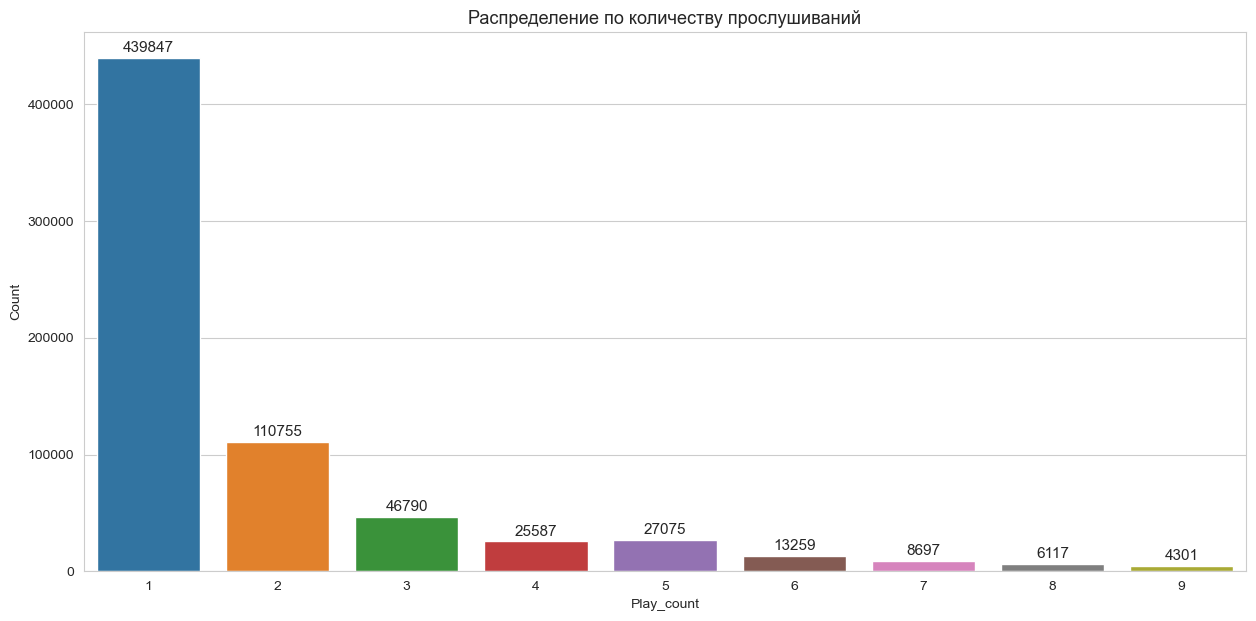

In [14]:
fig = plt.figure(figsize = (15, 7))

ax = sns.countplot(x='play_count', data=train);

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 5000, 
            rect.get_height(), horizontalalignment='center', fontsize = 11)

plt.title('Распределение по количеству прослушиваний', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

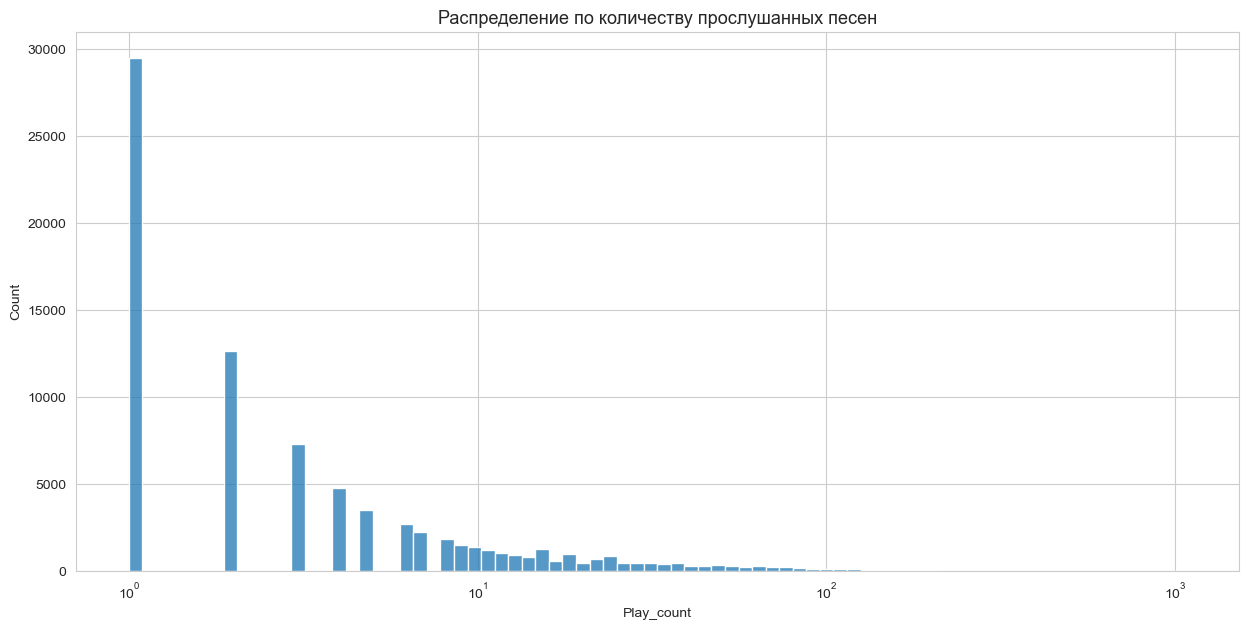

In [17]:
fig = plt.figure(figsize = (15, 7))

sns.histplot(train.groupby('song_id').size(), log_scale=True);

plt.title('Распределение по количеству прослушанных песен', fontsize=13);
plt.ylabel('Count', fontsize=10);
plt.xlabel('Play_count',  fontsize=10);

### Создаем матрицу для item-features

In [46]:
test_zero = test.copy()
test_zero['play_count'] = 0

Чтобы избежать переобучения обнулим количество прослушиваний песен для теста и объединим тест и трейн.

In [47]:
test_zero.head()

,user_id,song_id,play_count,title,release,artist_name,year,genre,artist_country,artist_city
0,1234,11506,0,You Appearing,Saturdays = Youth,M83,2008,electronic,France,Antibes
1,6261,56945,0,The Old Homestead (Remastered Album Version),Hawks & Doves,Neil Young,1980,rock,Canada,Toronto
2,9153,85415,0,One,...And Justice For All,Metallica,1988,rock,United States,Los Angeles
3,8483,87056,0,Tú,Shakira MTV Unplugged,Shakira,1998,pop,Colombia,Barranquilla
4,8246,69701,0,Hustla Balla Gangsta Mack,Rich Boy,Rich Boy,2007,hiphop,United States,Mobile


In [48]:
data_10k = pd.concat([train, test_zero])
data_10k.shape

(853035, 10)

In [49]:
song_10k = data_10k[['song_id', 'play_count', 'release', 'artist_name', 
                     'year', 'genre', 'artist_country', 'artist_city']].drop_duplicates()
song_10k.head()

,song_id,play_count,release,artist_name,year,genre,artist_country,artist_city
0,55701,1,Headstrong,Ashley Tisdale,2007,pop_rock,United States,Ocean Township
1,6227,1,Away We Go Original Motion Picture Soundtrack,Alexi Murdoch,2009,soundtrack,United Kingdom,London
2,48367,1,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,rock,United States,Berkeley
3,28004,1,Collide,Beats Antique,2008,electronic,United States,Oakland
4,3134,2,Hometowns,The Rural Alberta Advantage,2008,rock,Canada,Toronto


In [50]:
song_10k = song_10k.groupby(['song_id', 'release', 'artist_name', 'year', 'genre', 
                             'artist_country', 'artist_city'], as_index=False).agg({'play_count': 'sum'})

Получим датасет с уникальными песнями и их фичами, включая целевую переменную - play_count.

In [54]:
song_10k = song_10k.sort_values(by='song_id')
song_10k.head()

,song_id,release,artist_name,year,genre,artist_country,artist_city,play_count
0,0,The Room,Harold Budd,2000,ambient,United States,Los Angeles,0
1,1,Have Yourself A Tractors Christmas,The Tractors,1995,country,United States,Tulsa,1
2,2,At the Cut,Vic Chesnutt,2009,rock,United States,Jacksonville,0
3,3,20 Años,Alejandro Lerner,1998,latin,Argentina,Buenos Aires,3
4,4,Sefronia,Tim Buckley,1973,folk,United States,Washington,0


In [55]:
song_10k.shape

(88058, 8)

In [56]:
cat_cols = ['release', 'artist_name', 'year', 'genre', 'artist_country', 'artist_city']

In [57]:
pipe = Pipeline([('enc', LeaveOneOutEncoder(cols=cat_cols)), 
                ('scaler', StandardScaler())])

In [58]:
song_features = pipe.fit_transform(song_10k.drop('song_id', axis=1), song_10k.play_count)
song_features.shape

(88058, 7)

In [59]:
items_features = scs.csr_matrix(song_features)
items_features

<88058x7 sparse matrix of type '<class 'numpy.float64'>'
	with 616406 stored elements in Compressed Sparse Row format>

## Обучение моделей
### Random

In [34]:
def get_random_preds(k=10):
    preds = np.tile(np.arange(num_songs), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_songs)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds

### Popularity Based Filtering

In [35]:
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user, data in train.groupby('user_id'):
        user_preds = preds[user]
        new_preds[user] = user_preds[~np.in1d(user_preds, data.song_id)][:k]
    return new_preds


def get_toppop_preds(freq=10, k=10):
    mean_rating = train.groupby('song_id').play_count.mean()
    mean_rating = mean_rating[train.groupby('song_id').size() >= freq]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    preds = remove_train_items(preds, k)
    return preds

### ALS

In [30]:
def ALS(train_sparse, users: List, items: List, dim=64, n_iters=1, eps=1e-7):
    
    num_users = train_sparse.shape[0]
    num_items = train_sparse.shape[1]
    
    R = train_sparse.copy()
    print(R.shape)
    P = np.random.randn(num_users, dim)
    print(P.shape)
    Q = np.random.randn(num_items, dim)
    print(Q.shape)
    
    for t in tqdm(range(n_iters)):
        RQ = R @ Q
        for u in range(num_users):
            relevant_items = items[users == u]
            Q_rel = Q[relevant_items]
            QQ = Q_rel.reshape(-1, dim, 1) * Q_rel.reshape(-1, 1, dim)
            P[u] = np.linalg.inv(QQ.sum(axis=0) + eps * np.eye(dim)) @ RQ[u]

        RP = R.T @ P
        for i in range(num_items):
            relevant_users = users[items == i]
            P_rel = P[relevant_users]
            PP = P_rel.reshape(-1, dim, 1) * P_rel.reshape(-1, 1, dim)
            Q[i] = np.linalg.inv(PP.sum(axis=0) + eps * np.eye(dim)) @ RP[i]
    
    return P, Q

In [31]:
P, Q = ALS(train_sparse, train.user_id, train.song_id, n_iters=5)

(10000, 88058)
(10000, 64)
(88058, 64)


100%|██████████| 5/5 [11:59<00:00, 143.86s/it]


In [33]:
def get_ALS_preds(U, V, k=10):
    preds = np.argsort(U @ V.T, axis=1)
    preds = remove_train_items(preds, k)
    return preds

### Implicit ALS

In [133]:
user_items_data = train_sparse.copy().tocsr()

In [164]:
def get_implicit_pred(k):
    item_user_data = load_npz('train_10k_sparse_matrix.npz')
    model = AlternatingLeastSquares(factors=50)
    model.fit(item_user_data)
    implicit_pred = []
    user_items = item_user_data.T.tocsr()
    for i in range(10000):
        recommendations = model.recommend(i, user_items[i], N=k)[0]
        implicit_pred.append(recommendations)
    return implicit_pred

### LightFm

In [60]:
modelFM = LightFM(no_components=200,
                  loss='warp', 
                  user_alpha=6e-5, 
                  item_alpha=2e-5, 
                  learning_rate=0.01, 
                  random_state=42,
                  max_sampled=100)

In [61]:
epochs = 1
rounds = 10
for rounds in tqdm(range(rounds)):
    modelFM.fit_partial(train_sparse, 
                       sample_weight=train_sparse, 
                       epochs=epochs, 
                       num_threads=8,
                       item_features=items_features,
                       user_features=train_sparse)

In [62]:
modelFM = joblib.load('LightFM.pkl')

In [63]:
pred = []
for row_id in tqdm(np.arange(test_sparse.shape[0])):
    score = pd.Series(modelFM.predict(int(row_id), np.arange(test_sparse.shape[1]), 
                                      item_features=items_features,
                                      user_features=test_sparse,
                                      num_threads=8))
    score.index = np.arange(test_sparse.shape[1])
    score = list(pd.Series(score.sort_values(ascending=False).index))
    
    pred_items = score[:50]
    
    pred.append(pred_items)

### SVD

In [185]:
def get_SVD_pred(ks):
    u, s, vt = svds(train_sparse, k=10)
    s_diag_matrix = np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    
    pred_svd = []
    for row_id in tqdm(np.arange(test_sparse.shape[0])):
        score = pd.Series(X_pred[row_id, :])
        score = list(pd.Series(score.sort_values(ascending=False).index))

        pred_items = score[:ks]
        pred_svd.append(pred_items)
        
    return pred_svd

## Оценка качества

In [175]:
from metrics import MAP_k, MAR_k

Получим истинные и предсказанные значения для каждой модели.

In [36]:
true_relevant = []
for user, data in test[test.play_count >= 3].groupby('user_id'):
    true_relevant += [data.song_id.tolist()]

In [112]:
ks = np.arange(1, 31)

als_preds = get_ALS_preds(P, Q, k=ks[-1])
random_preds = get_random_preds(k=ks[-1])
top_preds = get_toppop_preds(freq=10, k=ks[-1])
pred_svd = get_SVD_pred(ks=ks[-1])

In [166]:
with open('LF_pred.pkl', 'rb') as f:
    pred_LF = pickle.load(f)
    
with open('IMP_pred.pkl', 'rb') as f:
    implicit_pred = pickle.load(f)

Оценим качество на метриках MAP_k и MAR_k.

In [179]:
random_map_k = [MAP_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAP_k(true_relevant, top_preds, k=k) for k in ks]
als_map_k = [MAP_k(true_relevant, als_preds, k=k) for k in ks]
LFM_map_k = [MAP_k(true_relevant, pred_LF, k=k) for k in ks]
impl_map_k = [MAP_k(true_relevant, implicit_pred, k=k) for k in ks]
SVD_map_k = [MAP_k(true_relevant, pred_svd, k=k) for k in ks]

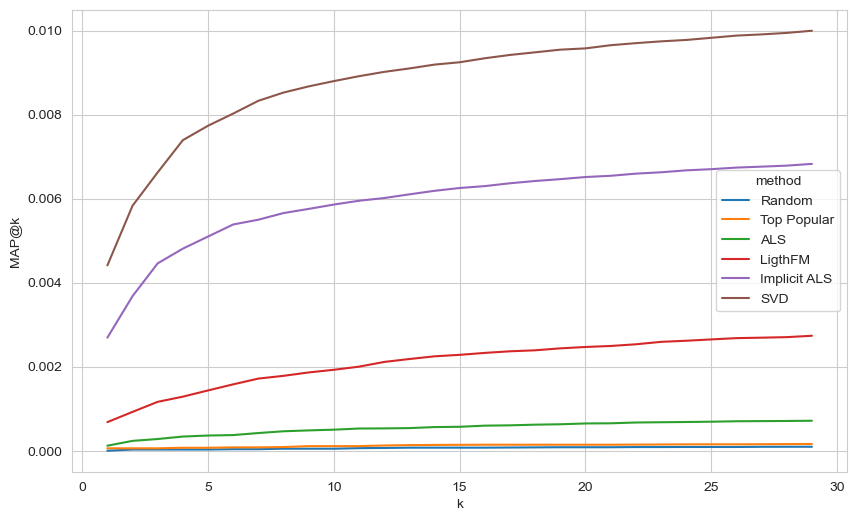

In [190]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')
plt.plot(ks, als_map_k, label='ALS')
plt.plot(ks, LFM_map_k, label='LigthFM')
plt.plot(ks, impl_map_k, label='Implicit ALS')
plt.plot(ks, SVD_map_k, label='SVD')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

In [176]:
random_mar_k = [MAR_k(true_relevant, random_preds, k=k) for k in ks]
top_mar_k = [MAR_k(true_relevant, top_preds, k=k) for k in ks]
als_mar_k = [MAR_k(true_relevant, als_preds, k=k) for k in ks]
LFM_mar_k = [MAR_k(true_relevant, pred_LF, k=k) for k in ks]
impl_mar_k = [MAR_k(true_relevant, implicit_pred, k=k) for k in ks]
SVD_mar_k = [MAR_k(true_relevant, pred_svd, k=k) for k in ks]

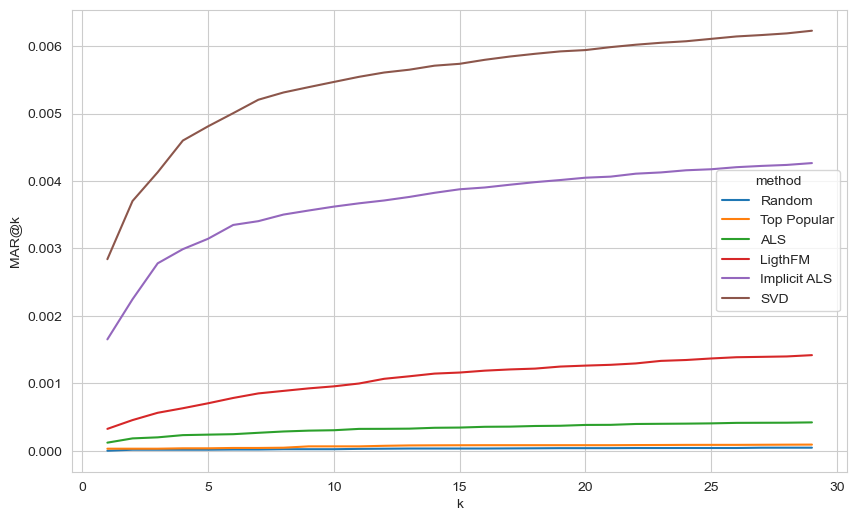

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_mar_k, label='Random')
plt.plot(ks, top_mar_k, label='Top Popular')
plt.plot(ks, als_mar_k, label='ALS')
plt.plot(ks, LFM_mar_k, label='LigthFM')
plt.plot(ks, impl_mar_k, label='Implicit ALS')
plt.plot(ks, SVD_mar_k, label='SVD')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAR@k')
plt.show()